In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



# Plot grid

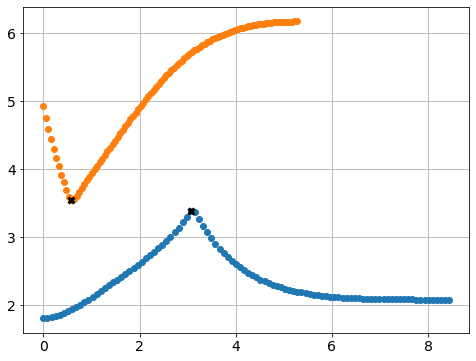

In [118]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"

list_sides = ["iu", "ou"]
data = dict()
sepadd = 2
res = 100

for side in list_sides:
    data[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "target_to_midplane", log_grid = False)
    
    
fig, ax= plt.subplots(figsize = (8,6))
for side in ["ou", "iu"]:
    ax.plot(data[side]["Spol"], data[side]["Btot"], marker = "o", linewidth = 0)
    ax.scatter(data[side]["Spol"][data[side]["Xpoint"]], data[side]["Btot"][data[side]["Xpoint"]], zorder = 10, marker = "x", color = "black")


# Make log grid

No handles with labels found to put in legend.


100


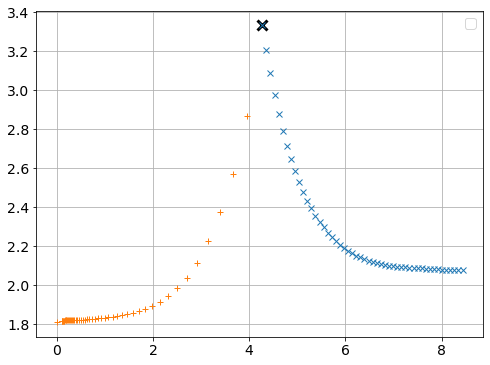

In [150]:
side = "ou"
d =  data[side]
Xpoint = d["Xpoint"]
Spolx = d["Spol"][Xpoint]
interp = interpolate.interp1d(d["Spol"], d["Btot"])

res = 100
abovex = np.linspace(d["Spol"][Xpoint], d["Spol"][-1], int(np.floor(res/2)))
belowx = np.logspace(-1, np.log10(d["Spol"][Xpoint]), int(np.ceil(res/2))) 
belowx = np.insert(belowx, 0, 0)
belowx = np.delete(belowx, -1)
grid = np.concatenate([belowx, abovex])
belowx
y_abovex = interp(abovex)
y_belowx = interp(belowx)
y_new = interp(grid)
print(len(grid))
fig, ax= plt.subplots(figsize = (8,6))
# for side in ["ou", "iu"]:

xidx = len(belowx)

ax.plot(abovex, y_abovex, zorder = 10, marker = "x", linewidth = 0)
ax.plot(belowx, y_belowx, zorder = 10, marker = "+", linewidth = 0)
# ax.plot(grid, y_new, label = "full interp")
# ax.plot(d["Spol"], d["Btot"], label = "original")
ax.scatter(grid[xidx], y_new[xidx], color = "black", s=100, marker="x")
# ax.set_xlim(0,1)
ax.legend()

# Make dynamic grid

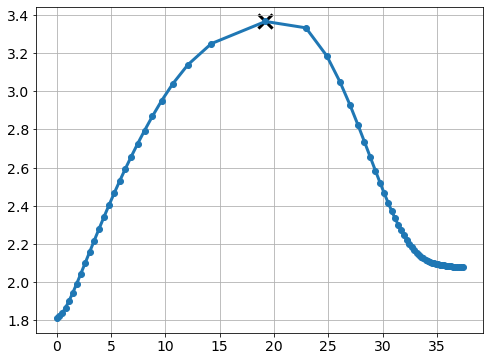

In [13]:
plt.plot(d["S"], d["Btot"], marker = "o")
plt.scatter(d["S"][d["Xpoint"]], d["Btot"][d["Xpoint"]], color = "black", s = 200, marker = "x")

1000

In [130]:
side = "ou"

d =  data[side]
Xpoint = d["Xpoint"]
Spolx = d["Spol"][Xpoint]
Sx = d["S"][Xpoint]

# UP TO IS EXCLUSIVE. FROM IS INCLUSIVE

res = 100
Sfront = 0.5*Sx
front_index = np.argmin(abs(d["S"] - Sfront))
# idfront = 995

below = dict(); front = dict(); above = dict()

for param in ["S", "Btot", "Bpol", "Spol"]:
    below[param] = d[param][:idfront]
    front[param] = d[param][front_index:Xpoint+1]
    above[param] = d[param][Xpoint+1:]

new_front = dict()
new_front["S"] = np.linspace(front["S"][0], front["S"][-1], res)

d2 = dict()
for param in ["Btot", "Bpol", "Spol"]:
    interp = interpolate.interp1d(front["S"], front[param], kind = "cubic")

    new_front[param] = interp(new_front["S"])
    d2[param] = np.concatenate([below[param], new_front[param], above[param]])

d2["S"] = np.concatenate([below["S"], new_front["S"], above["S"]])
d2["Xpoint"] = len(below["S"]) + len(new_front["S"]) -1
    




Text(0, 0.5, 'Btot')

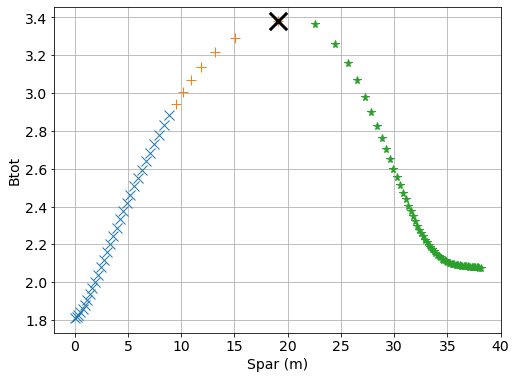

In [131]:
fig, ax = plt.subplots()
ax.plot(below["S"], below["Btot"], marker = "x", markersize = 10, linewidth  = 0)
ax.plot(front["S"], front["Btot"], marker = "+", markersize = 10, linewidth  = 0)
ax.plot(above["S"], above["Btot"], marker = "*", markersize = 8, linewidth  = 0)
ax.scatter(d["S"][d["Xpoint"]], d["Btot"][d["Xpoint"]], s = 300, marker = "x", facecolor = "black", zorder = 50, label = "Xpoint")
ax.set_xlabel("Spar (m)")
ax.set_ylabel("Btot")
# ax.plot(d["S"], d["Btot"], marker = "o", markerfacecolor = "None", markersize = 8, linewidth  = 0)

Text(0, 0.5, 'Btot')

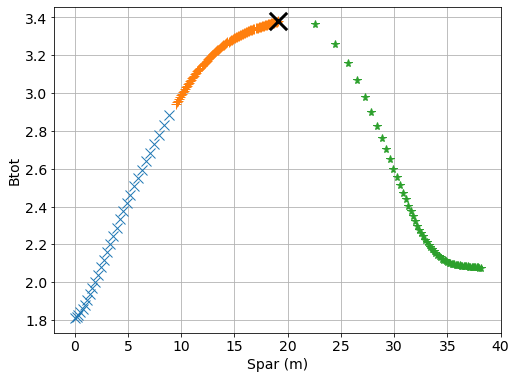

In [132]:
fig, ax = plt.subplots()
ax.plot(below["S"], below["Btot"], marker = "x", markersize = 10, linewidth  = 0)
ax.plot(new_front["S"], new_front["Btot"], marker = "+", markersize = 10, linewidth  = 0)
ax.plot(above["S"], above["Btot"], marker = "*", markersize = 8, linewidth  = 0)
ax.scatter(d2["S"][d2["Xpoint"]], d2["Btot"][d2["Xpoint"]], s = 300, marker = "x", facecolor = "black", zorder = 50, label = "Xpoint")
ax.set_xlabel("Spar (m)")
ax.set_ylabel("Btot")
# ax.plot(d["S"], d["Btot"], marker = "o", markerfacecolor = "None", markersize = 8, linewidth  = 0)

## Function test

In [139]:
def dynamic_grid(d, res, front_index):
    d =  data[side]
    Xpoint = d["Xpoint"]
    Spolx = d["Spol"][Xpoint]
    Sx = d["S"][Xpoint]

    # UP TO IS EXCLUSIVE. FROM IS INCLUSIVE
    below = dict(); front = dict(); above = dict()

    for param in ["S", "Btot", "Bpol", "Spol"]:
        below[param] = d[param][:idfront]
        front[param] = d[param][front_index:Xpoint+1]
        above[param] = d[param][Xpoint+1:]

    new_front = dict()
    new_front["S"] = np.linspace(front["S"][0], front["S"][-1], res)

    d2 = dict()
    for param in ["Btot", "Bpol", "Spol"]:
        interp = interpolate.interp1d(front["S"], front[param], kind = "cubic")

        new_front[param] = interp(new_front["S"])
        d2[param] = np.concatenate([below[param], new_front[param], above[param]])

    d2["S"] = np.concatenate([below["S"], new_front["S"], above["S"]])
    d2["Xpoint"] = len(below["S"]) + len(new_front["S"]) -1
    
    return d2

Text(0, 0.5, 'Btot')

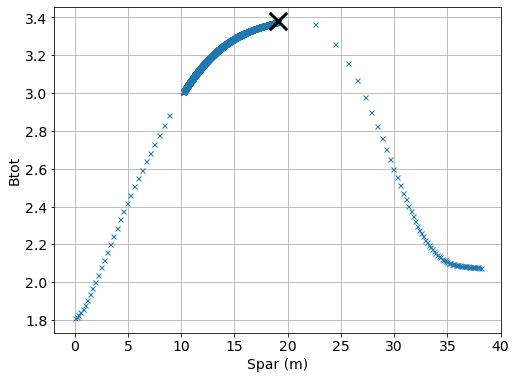

In [147]:
Sfront = 0.5*Sx
front_index = np.argmin(abs(d["S"] - Sfront))
front_index = d["Xpoint"]-5

d2 = dynamic_grid(d, 1000, front_index)

fig, ax = plt.subplots()

ax.plot(d2["S"], d2["Btot"], marker = "x", markersize = 5, linewidth  = 0)
ax.scatter(d2["S"][d2["Xpoint"]], d2["Btot"][d2["Xpoint"]], s = 300, marker = "x", facecolor = "black", zorder = 50, label = "Xpoint")
ax.set_xlabel("Spar (m)")
ax.set_ylabel("Btot")
# ax.plot(d["S"], d["Btot"], marker = "o", markerfacecolor = "None", markersize = 8, linewidth  = 0)

In [73]:
np.log10(0.1)

[autoreload of unpackConfigurationsMK failed: Traceback (most recent call last):
  File "C:\Apps\Anaconda3\envs\py38\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Apps\Anaconda3\envs\py38\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Apps\Anaconda3\envs\py38\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Apps\Anaconda3\envs\py38\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\Mike\OneDrive\Project\D

-1.0

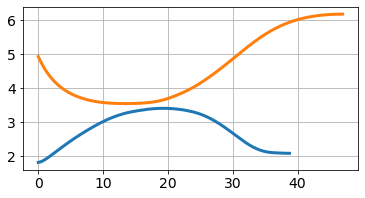

In [7]:


# np.diff(data["iu"]["S"])